In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
from model.dataset import Dataset
from model.losses import QuantileLoss
from model.model import QuantileNet

In [2]:
PATH_DATA = Path.cwd() / 'data' / 'files'

In [3]:
data = pd.read_csv((PATH_DATA / 'data.csv'), index_col='time')

In [4]:
data.head(2)

,u100_mean_36.0-5.45,u100_mean_36.0-5.95,u100_mean_36.0-6.45,u100_mean_36.5-5.45,u100_mean_36.5-5.95,u100_mean_36.5-6.45,u100_mean_37.0-5.45,u100_mean_37.0-5.95,u100_mean_37.0-6.45,v100_mean_36.0-5.45,...,sp_spread_36.0-5.45,sp_spread_36.0-5.95,sp_spread_36.0-6.45,sp_spread_36.5-5.45,sp_spread_36.5-5.95,sp_spread_36.5-6.45,sp_spread_37.0-5.45,sp_spread_37.0-5.95,sp_spread_37.0-6.45,production
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,0.240008,-1.134381,-1.759686,-0.840131,-2.014142,-2.166547,-2.445111,-3.015729,-2.189557,-3.024733,...,8.433892,8.393884,7.917718,8.122979,7.941735,7.307031,7.844842,7.255090,6.620324,593.580
2015-01-01 03:00:00,0.267507,-0.814769,-1.232799,-1.299937,-2.336314,-2.264842,-2.922008,-3.598949,-2.659495,-3.378693,...,5.420375,6.943202,8.109828,5.365626,7.012294,7.987330,7.272120,7.877955,7.534816,533.846


Convert the dataframe into a pytorch tensor

In [5]:
data_tensor = torch.tensor(data.values, dtype=torch.float32)

Split the data into train, validation and test

In [6]:
n_val = 1000
n_test = 1000
n_train = len(data_tensor) - (n_val + n_test)

data_train =  data_tensor[:n_train, :]
data_val =  data_tensor[n_train:n_train + n_val, :]
data_test =  data_tensor[-n_test:, :]

Scale the variables

In [7]:
scaler = MinMaxScaler()
scaler.fit(data_train)

train_scaled = scaler.transform(data_train)

In [8]:
inputs, target = train_scaled[:, :-1], train_scaled[:, -1:]

In [9]:
quantilenet = QuantileNet()
print(quantilenet)

QuantileNet(
  (layers): Sequential(
    (0): Linear(in_features=126, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=2, bias=True)
  )
)


For this example we will use the quantiles 0.05 and 0.95

In [10]:
quantiles = torch.tensor([.05, .95])

In [11]:
optimizer = optim.SGD(quantilenet.parameters(), lr=0.003)

dataset = Dataset(inputs, target)
trainloader = DataLoader(dataset=dataset, batch_size=64)
criterion = QuantileLoss(quantiles)

Train the model

In [26]:
loss_list = []

for epoch in range(1000):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # inputs and target
        inputs, target = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = quantilenet(inputs)
        loss = criterion(outputs, target)
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        if i % 1000 == 0:    # print every 1000 mini-batches
            print(i)
            print(f'epoch: {epoch + 1}, batch: {i + 1}, loss: {running_loss}')
            
            loss_list.append(running_loss)
            running_loss = 0.0
            

print('Finished Training')

Finished Training


Loss results

In [13]:
import matplotlib.pyplot as plt

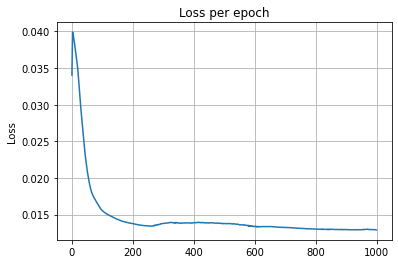

In [14]:
loss_ss = pd.Series(loss_list[1:])
loss_ss.plot()
plt.ylabel('Loss')
plt.title('Loss per epoch')
plt.grid()

Predictions validation set

In [18]:
val_scaled = scaler.transform(data_val)
inputs, target = val_scaled[:, :-1], val_scaled[:, -1:]

inputs = torch.tensor(inputs, dtype=torch.float32)
target = torch.tensor(target, dtype=torch.float32)

In [19]:
y_pred = quantilenet(inputs)
y_test = pd.Series(target.squeeze().tolist())
y_preds = pd.DataFrame(y_pred.tolist())

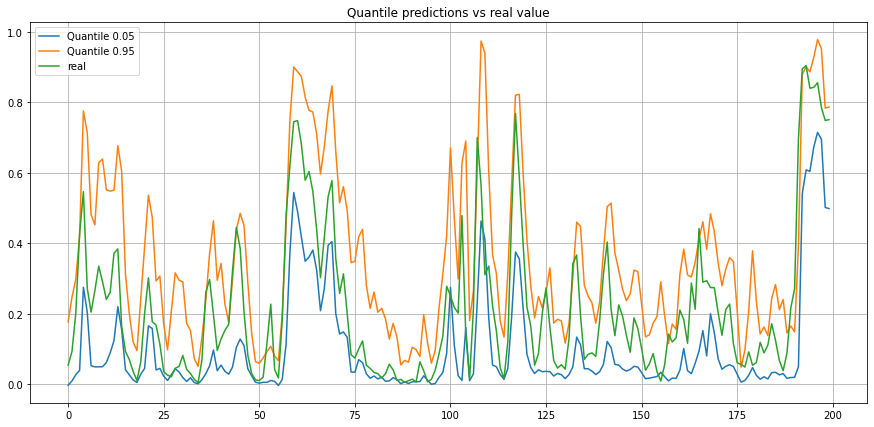

In [22]:
fig, ax = plt.subplots(figsize=(15, 7))
y_preds[:200].plot(ax=ax)
y_test[:200].plot(ax=ax)
ax.legend(['Quantile 0.05', 'Quantile 0.95', 'real'])
ax.set_title('Quantile predictions vs real value')
plt.grid()

In [24]:
out_low = (y_test < y_preds[0]).sum() / len(y_test)
out_high = (y_test > y_preds[1]).sum() / len(y_test)

In [25]:
print(f'pct of time real value is below the predicted 0.05 quantile: {out_low}')
print(f'pct of time real value is below the predicted 0.95 quantile: {out_high}')

pct of time real value is below the predicted 0.05 quantile: 0.058
pct of time real value is below the predicted 0.95 quantile: 0.061
